In [ ]:
# 1. Imports and Constants
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# MobileNetV3-specific
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Medicinal Leaf dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)

Found 741 files belonging to 7 classes.


In [ ]:
# 3. Train/Val/Test Split
train_size = int(0.8 * len(list(dataset)))
val_size = int(0.1 * len(list(dataset)))

dataset = dataset.shuffle(1000, seed=12)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

In [ ]:
# 4. Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
])

In [ ]:
# 5. Prefetch for Performance
train_ds = train_ds.cache().map(lambda x, y: (data_augmentation(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# 6. Define Model using MobileNetV3
base_model = MobileNetV3Small(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                              include_top=False,
                              weights='imagenet')


In [ ]:
# Fine-tune last few layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

model = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 7. Training with Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/saved_models/mobilenetv3_model.keras',
        save_best_only=True
    )
]

EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.1670 - loss: 2.5231 - val_accuracy: 0.3784 - val_loss: 1.7047
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3154 - loss: 1.7913 - val_accuracy: 0.4595 - val_loss: 1.3894
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4784 - loss: 1.4921 - val_accuracy: 0.5946 - val_loss: 1.1509
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5865 - loss: 1.2476 - val_accuracy: 0.6757 - val_loss: 0.9530
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6373 - loss: 1.0913 - val_accuracy: 0.7027 - val_loss: 0.7868
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7412 - loss: 0.8519 - val_accuracy: 0.7568 - val_loss: 0.6822
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7867 - loss: 0.6988 - val_accuracy: 0.7838 - val_loss: 0.6313
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8024 - loss: 0.5861 - val_accuracy: 0.8108 - val_loss:

In [ ]:
# 8. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.9779 - loss: 0.0802
Test Loss: 0.0943012535572052
Test Accuracy: 0.9791666865348816


In [ ]:
# 9. Calculate Precision, Recall, F1-Score
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step

Classification Report:

              precision    recall  f1-score   support

    Aloevera       1.00      1.00      1.00         9
      Bamboo       0.92      1.00      0.96        12
      Chilly       1.00      1.00      1.00        12
  Eucalyptus       1.00      0.89      0.94         9
       Guava       0.96      1.00      0.98        22
    Hibiscus       1.00      1.00      1.00        16
   Jackfruit       1.00      0.94      0.97        16

    accuracy                           0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96



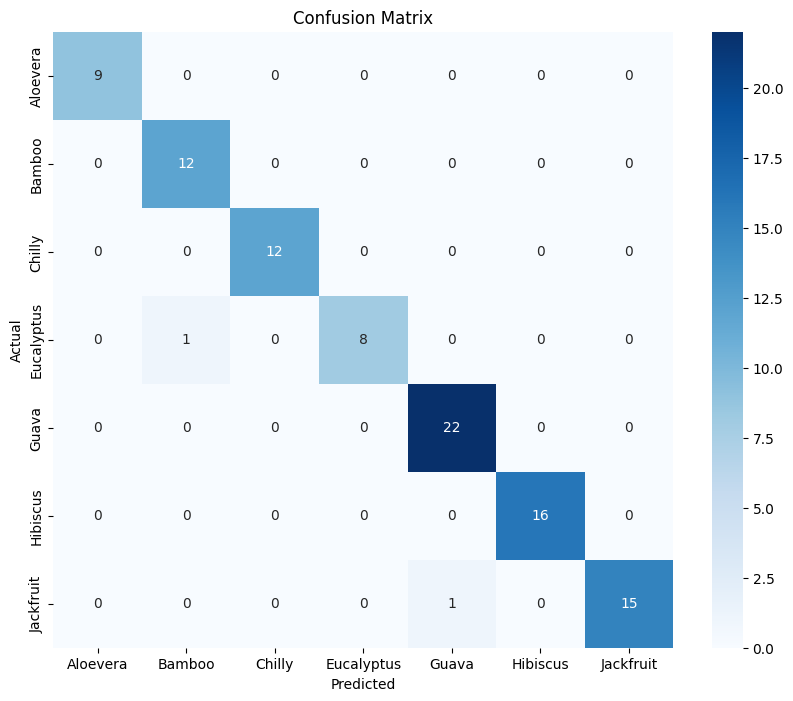

In [ ]:
# 10. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

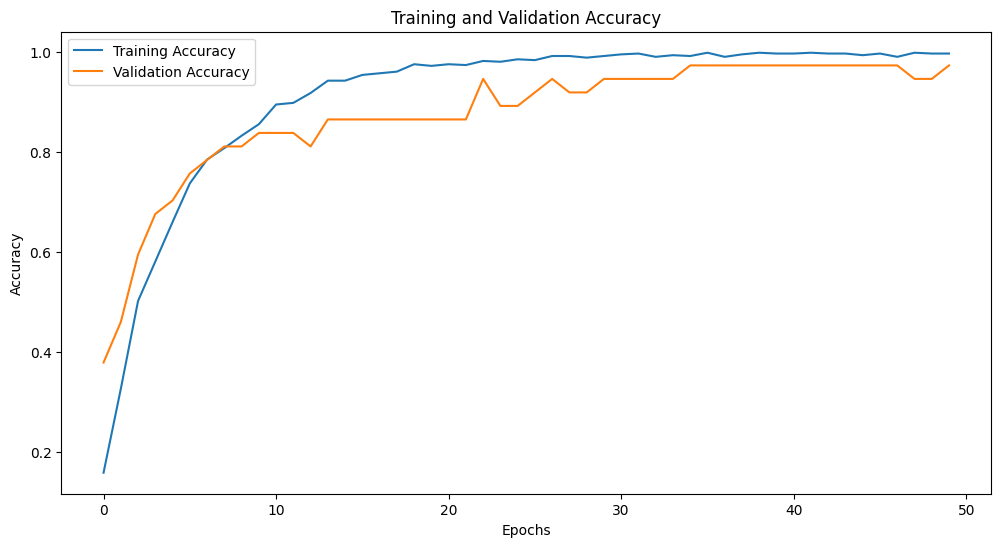

In [27]:
# 11. Training and Validation Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


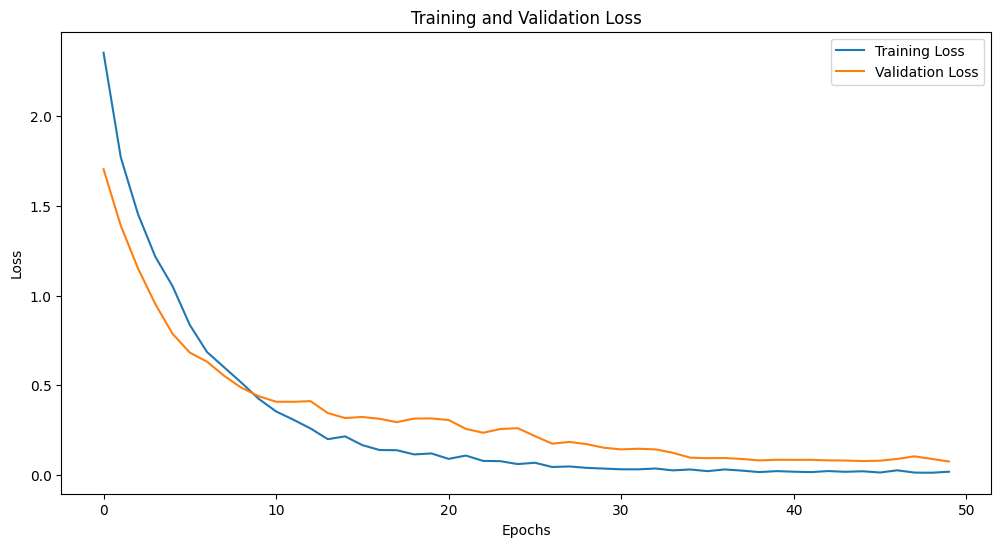

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()